In [70]:
import bagpy
import folium
import pandas as pd
from bagpy import bagreader
from geopy.distance import geodesic
from IPython.display import HTML, display
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import seaborn as sns
%matplotlib notebook
pd.set_option("display.precision", 12)
#
# Author: Nathaniel Hanson
# Date: 02/16/2021
# Purpose: Stationary GPS Data Analysis
#

In [78]:
### Stationary Data Analysis
bagFile = './record-stationary_2021-02-16-23-07-42.bag'
stationary = bagreader(bagFile)
# Show topic in bag files
print(stationary.topic_table)
# Convert topics to a Pandas data frame
dataStat = pd.read_csv(stationary.message_by_topic('/gps_data'))

[INFO]  Data folder ./record-stationary_2021-02-16-23-07-42 already exists. Not creating.
      Topics            Types  Message Count       Frequency
0  /gps_data   gps_driver/GPS            200  3.278649363156
1  /raw_data  std_msgs/String            750  9.883624864210


In [79]:
# Plot locations on a map
m = folium.Map(
    location=[42.351944, -71.077415],
    max_zoom=20,
    zoom_start=19
)
temp = dataStat.apply(lambda row:folium.CircleMarker(location=[row["lat"], 
                                                  row["lon"]]).add_to(m),
         axis=1)
# Plot Mean Location
folium.CircleMarker(
    location=[*list(dataStat.mean()[['lat','lon']])],
    color="red"
).add_to(m)
# Plot True Location
true_loc = [42.352173, -71.077155]
folium.CircleMarker(
    location=[*true_loc],
    color="green"
).add_to(m)
display(m)

In [93]:
# Calculate distance from true location to all points
dataStat['error_loc'] = dataStat.apply(
    lambda row: geodesic([row['lat'], row['lon']], true_loc).meters,
    axis = 1)
# True altitude determined from
# https://en-us.topographic-map.com/maps/f02f/Boston/
true_alt = 6.7056 # meters
true_utm = [328901.81, 4690968.93]
dataStat['error_abs'] = dataStat.apply(
    lambda row: np.sqrt(np.sum(
        (np.array([row['utm_easting'], row['utm_northing']]) - 
        np.array(true_utm))**2)),
    axis = 1)
dataStat['error_east'] = dataStat.apply(
    lambda row: np.sqrt(
        (row['utm_easting']-true_utm[0])**2),
    axis = 1)
dataStat['error_north'] = dataStat.apply(
    lambda row: np.sqrt(
        (row['utm_northing']-true_utm[1])**2),
    axis = 1)
dataStat['error_alt'] = dataStat.apply(
    lambda row: np.sqrt(
        (row['altitude']-true_alt)**2),
    axis = 1)
dataStat['time_elapsed'] =dataStat.apply(
    lambda row: (row['header.stamp.secs'] - dataStat.min()['header.stamp.secs'])*10,
    axis = 1
)

<IPython.core.display.Javascript object>


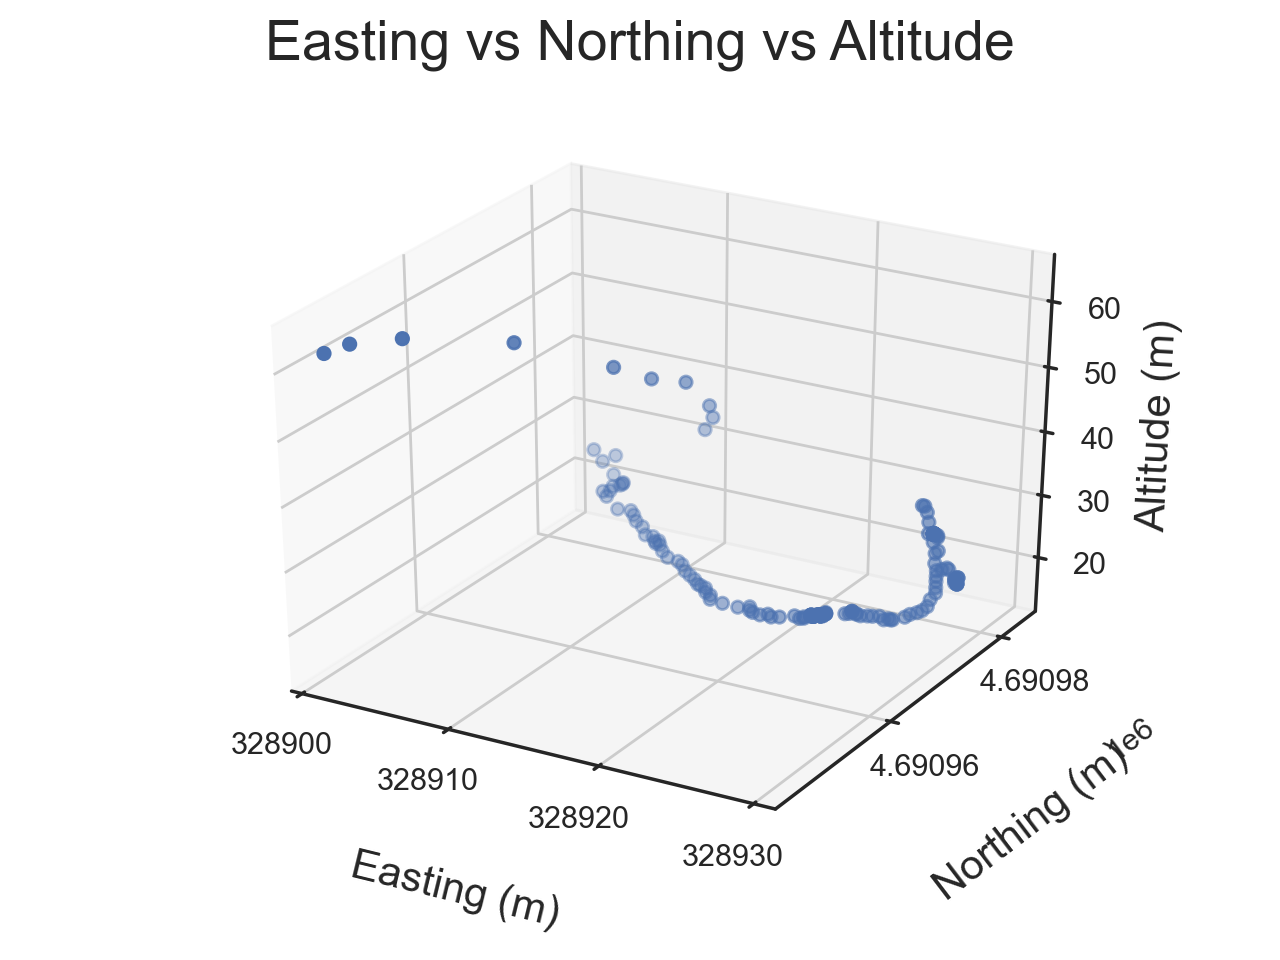

<IPython.core.display.Javascript object>


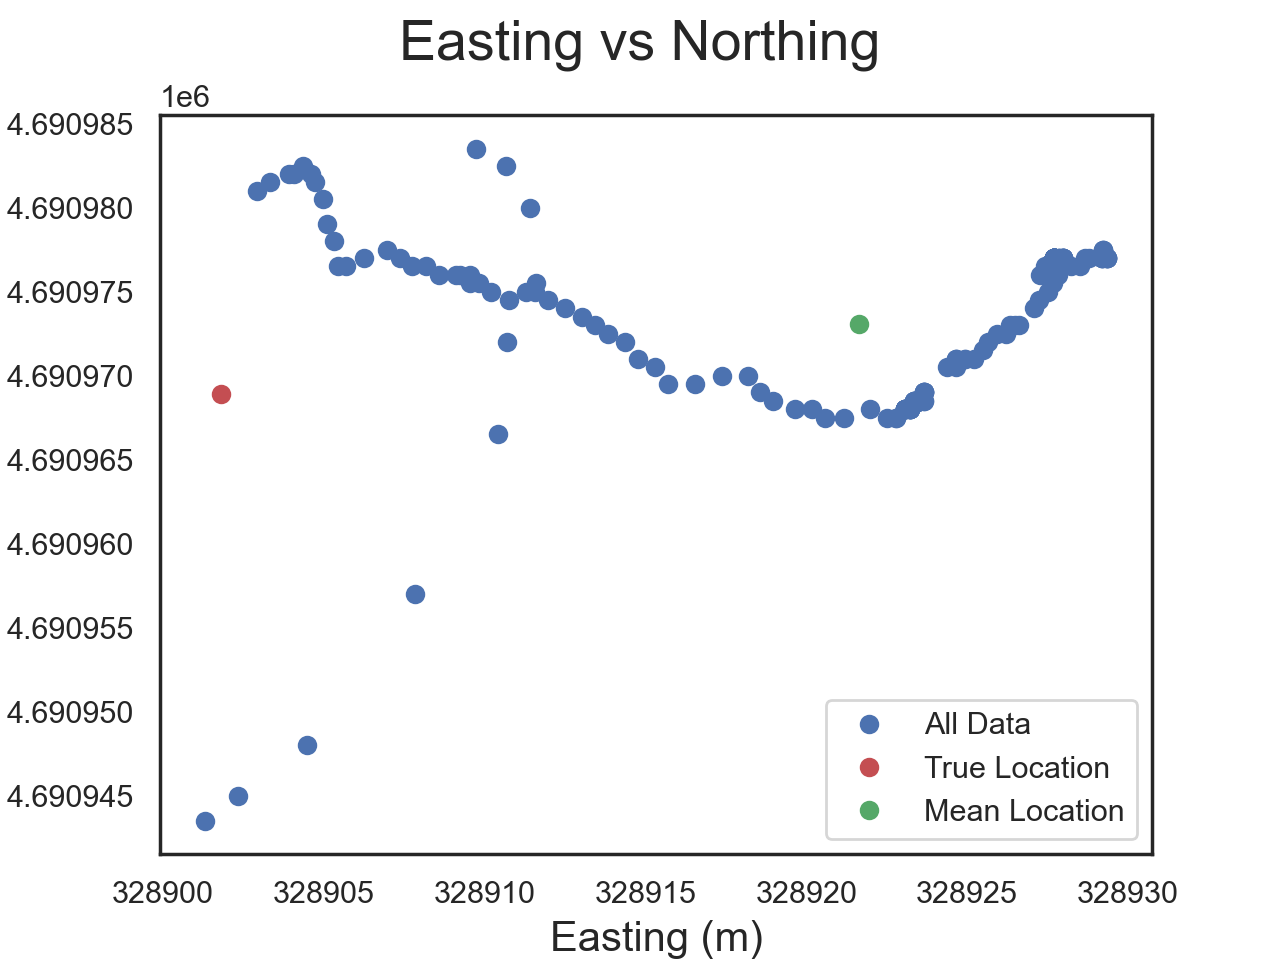

In [81]:
# Plot the surface.
fig = plt.figure()
ax = fig.gca(projection='3d')

# Surface plot data
x = dataStat['utm_easting']
y = dataStat['utm_northing']
z = dataStat['altitude']

surf = ax.scatter(x,y,z)
# title and labels, setting initial sizes
fig.suptitle('Easting vs Northing vs Altitude', fontsize=20)
ax.set_xlabel('Easting (m)', fontsize=15, labelpad = 20)
ax.set_ylabel('Northing (m)', fontsize=15, labelpad = 20)   # relative to plt.rcParams['font.size']
ax.set_zlabel('Altitude (m)', fontsize=15)   # relative to plt.rcParams['font.size']
ax.ticklabel_format(useOffset=False)
plt.locator_params(axis="y", nbins=4)
plt.locator_params(axis="x", nbins=4)

# Location over time in two deimensions
fig2 = plt.figure()
ax2 = fig2.gca()
plt.plot(dataStat['utm_easting'], dataStat['utm_northing'], 'bo', label='All Data')
plt.plot(true_utm[0], true_utm[1], 'ro', label='True Location')
plt.plot(dataStat['utm_easting'].mean(), dataStat['utm_northing'].mean(), 'go', label='Mean Location')
fig2.suptitle('Easting vs Northing', fontsize=20)
ax2.set_xlabel('Easting (m)', fontsize=15)
ax2.set_ylabel('Northing (m)', fontsize=15, labelpad=20)   # relative to plt.rcParams['font.size']
ax2.ticklabel_format(useOffset=False)
ax2.legend()

<IPython.core.display.Javascript object>


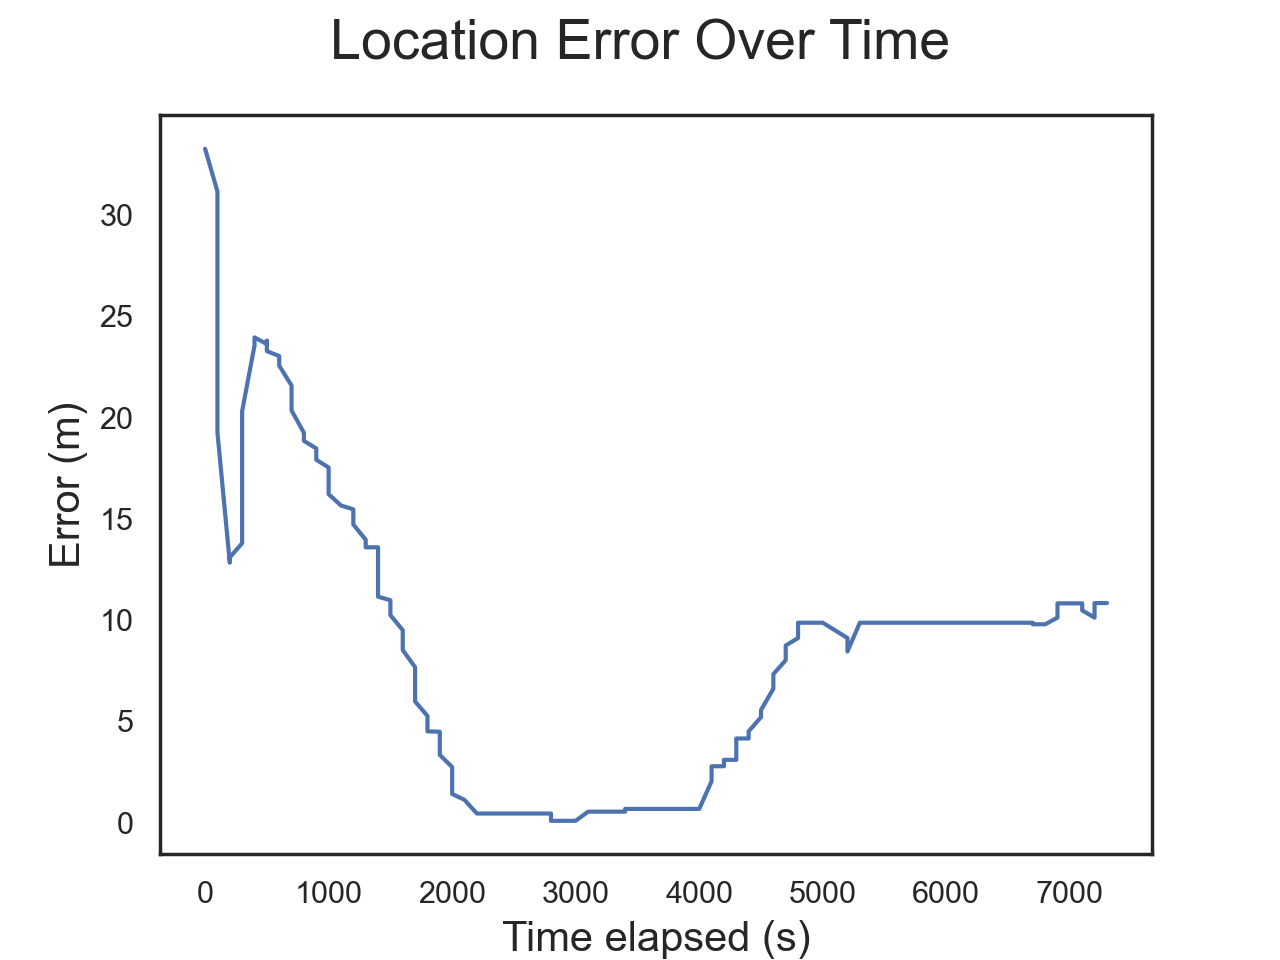

<IPython.core.display.Javascript object>


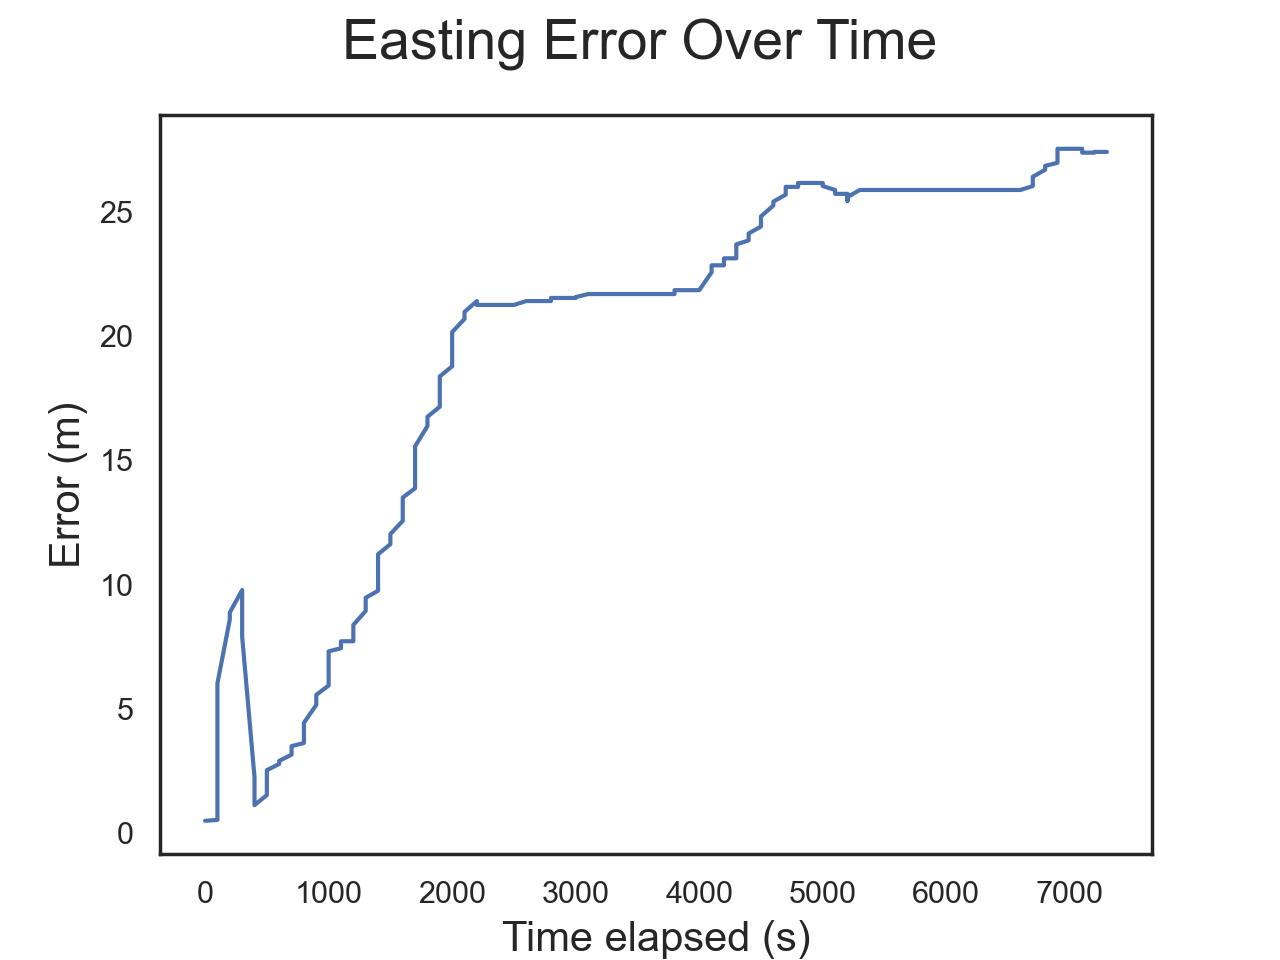

<IPython.core.display.Javascript object>


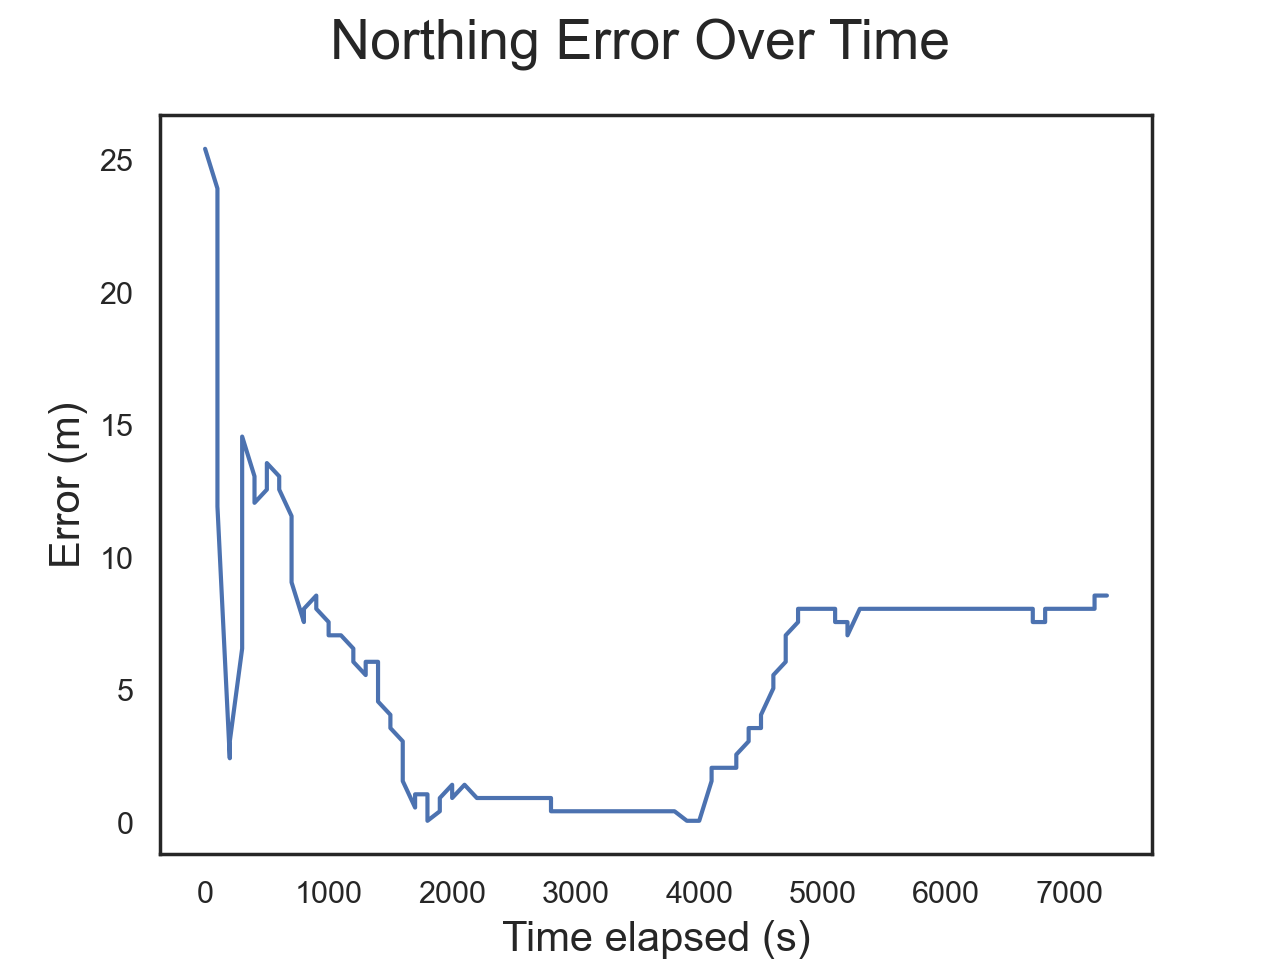

In [83]:
### Plot progressive error measurements over time

# Seeks to answer the question, is our error increasing or decreasing?
# Or following some unknown stochastic process
# Location error over time
fig2 = plt.figure()
ax2 = fig2.gca()
plt.plot(dataStat['time_elapsed']*10, dataStat['error_loc'])
fig2.suptitle('Location Error Over Time', fontsize=20)
ax2.set_xlabel('Time elapsed (s)', fontsize=15)
ax2.set_ylabel('Error (m)', fontsize=15)
ax2.ticklabel_format(useOffset=False)
# Easting error over time
fig3 = plt.figure()
ax3 = fig3.gca()
plt.plot(dataStat['time_elapsed']*10, dataStat['error_east'])
fig3.suptitle('Easting Error Over Time', fontsize=20)
ax3.set_xlabel('Time elapsed (s)', fontsize=15)
ax3.set_ylabel('Error (m)', fontsize=15)
ax3.ticklabel_format(useOffset=False)
# Northing error over time
fig4 = plt.figure()
ax4 = fig4.gca()
plt.plot(dataStat['time_elapsed']*10, dataStat['error_north'])
fig4.suptitle('Northing Error Over Time', fontsize=20)
ax4.set_xlabel('Time elapsed (s)', fontsize=15)
ax4.set_ylabel('Error (m)', fontsize=15)
ax4.ticklabel_format(useOffset=False)

<IPython.core.display.Javascript object>


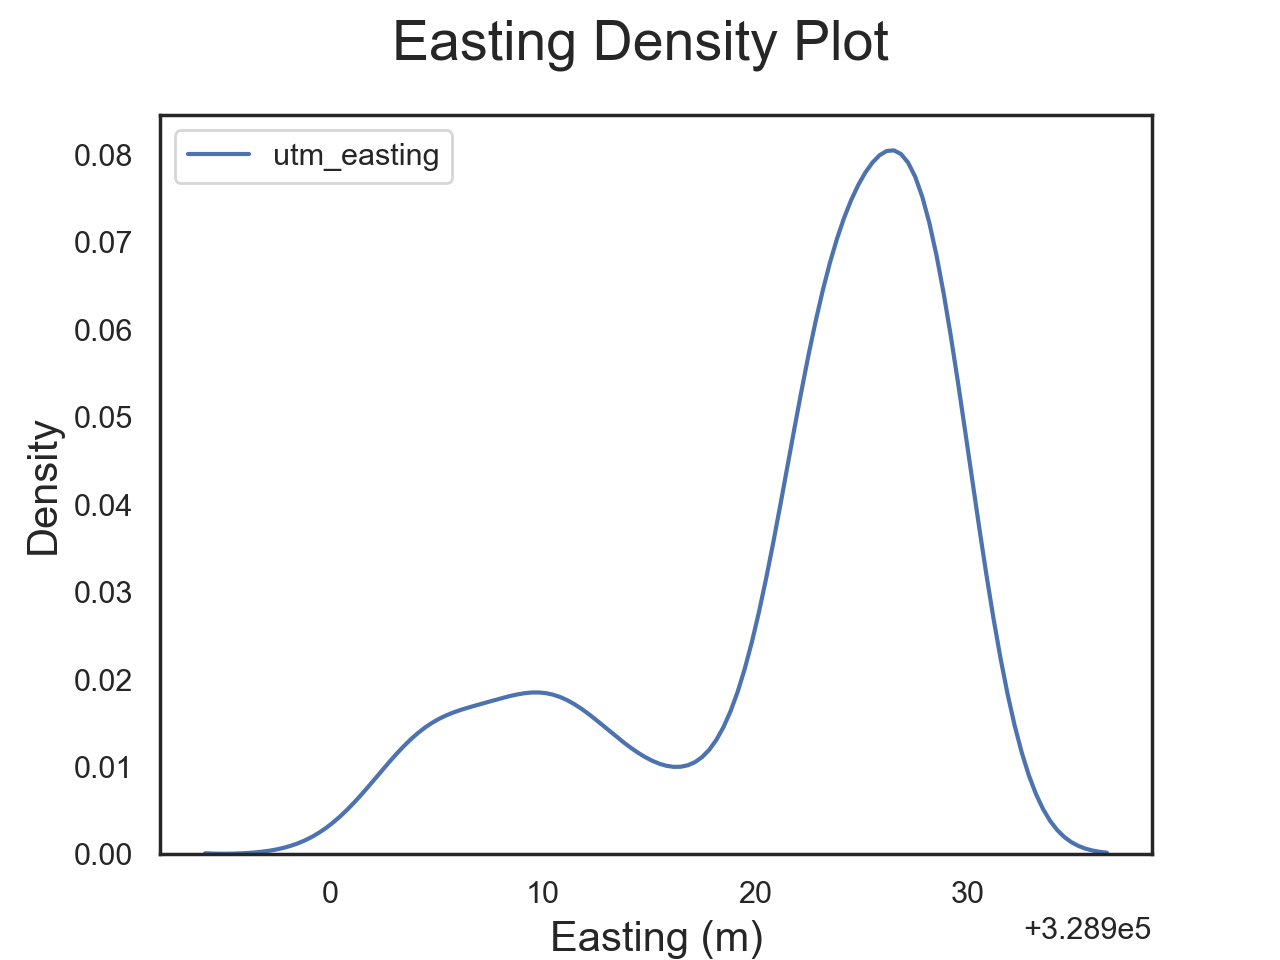

<IPython.core.display.Javascript object>


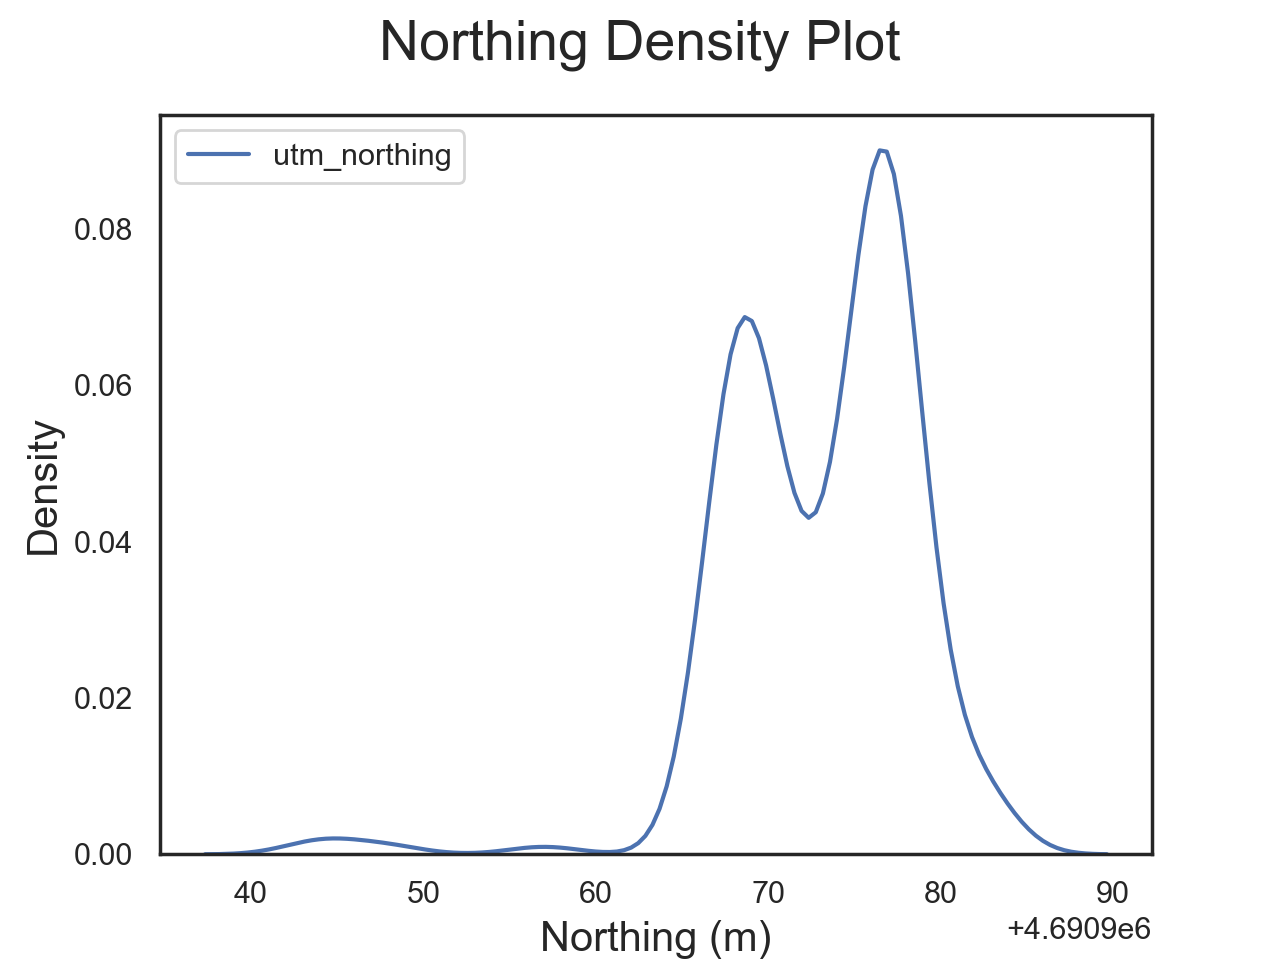

<IPython.core.display.Javascript object>


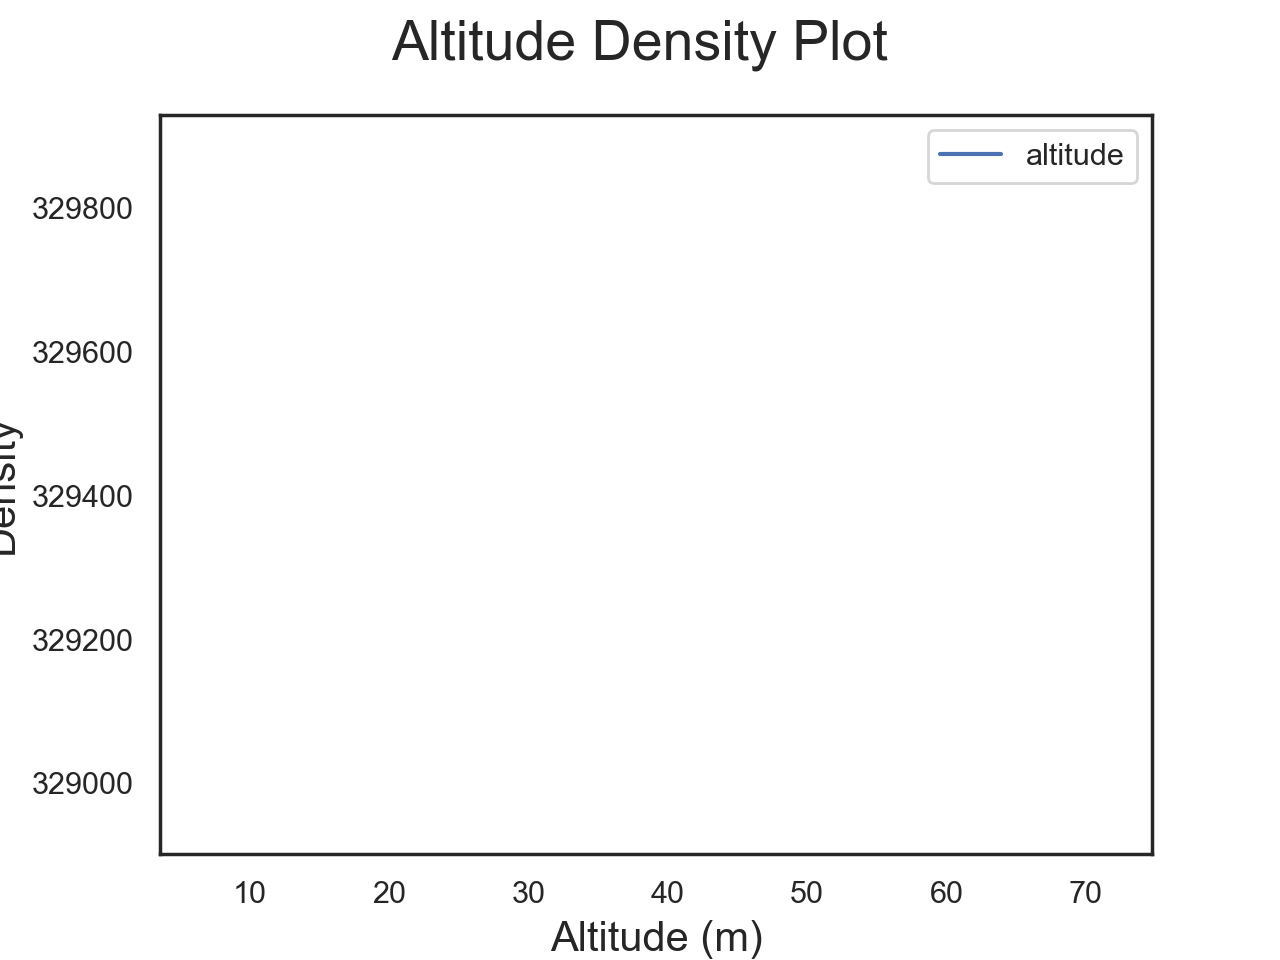

Text(0, 0.5, 'Density')

In [84]:
# Location point distribution over time
# Easting
fig2 = plt.figure()
ax2 = fig2.gca()
sns.kdeplot(dataStat['utm_easting'])
fig2.suptitle('Easting Density Plot', fontsize=20)
ax2.set_xlabel('Easting (m)', fontsize=15)
ax2.set_ylabel('Density', fontsize=15) 
fig2 = plt.figure()
ax2 = fig2.gca()
# Northing
sns.kdeplot(dataStat['utm_northing'])
fig2.suptitle('Northing Density Plot', fontsize=20)
ax2.set_xlabel('Northing (m)', fontsize=15)
ax2.set_ylabel('Density', fontsize=15) 
fig2 = plt.figure()
ax2 = fig2.gca()
# Altitude
sns.kdeplot(dataStat['altitude'])
fig2.suptitle('Altitude Density Plot', fontsize=20)
ax2.set_xlabel('Altitude (m)', fontsize=15)
ax2.set_ylabel('Density', fontsize=15) 

<IPython.core.display.Javascript object>


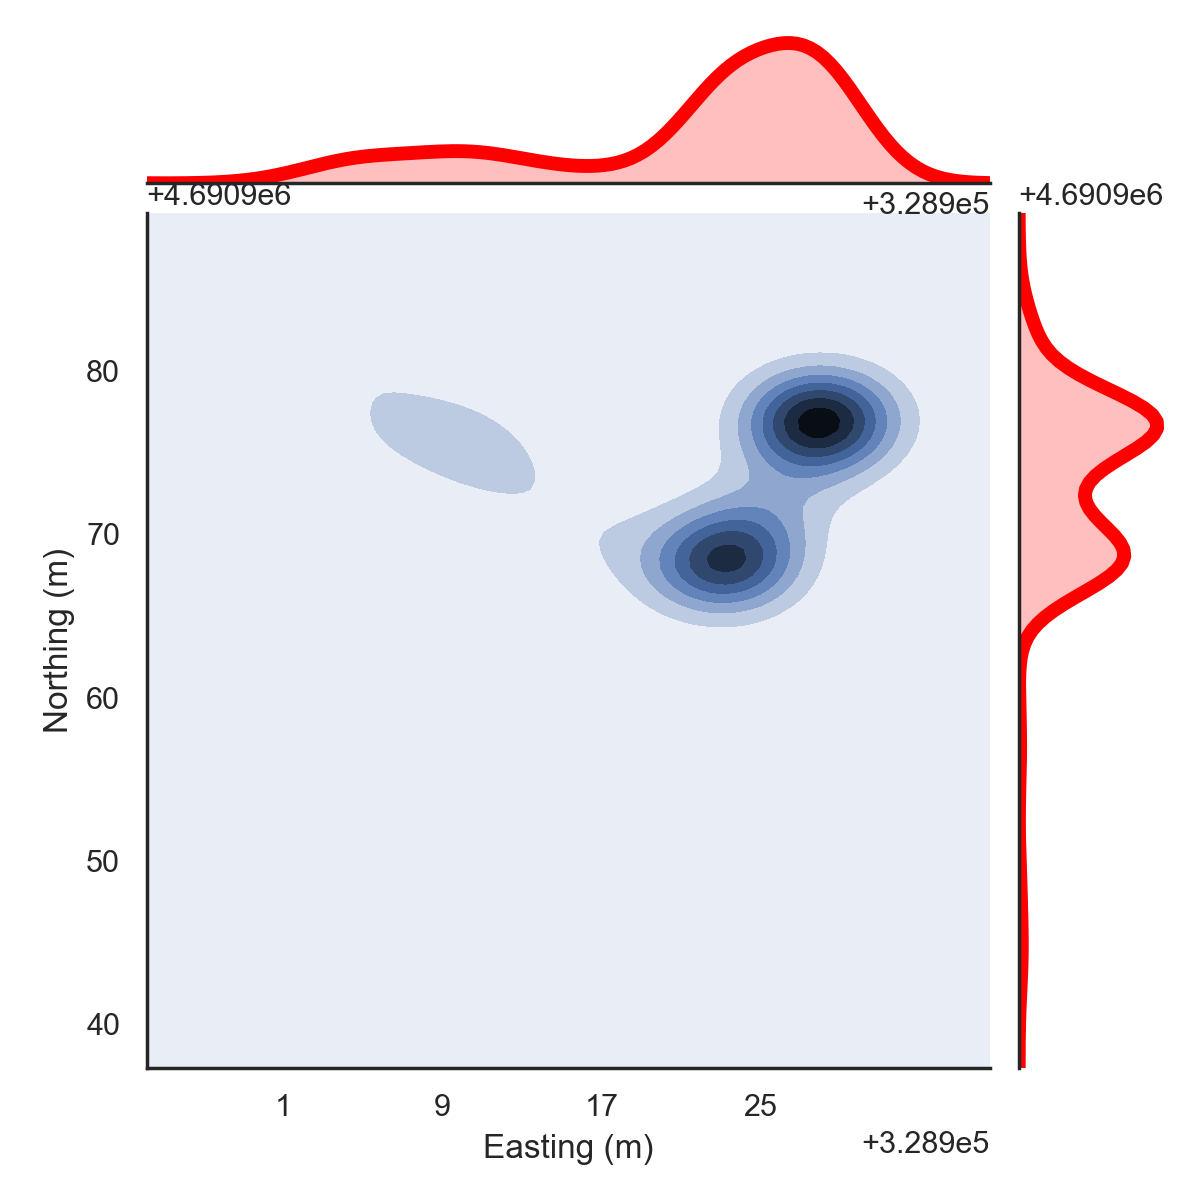

In [85]:
# 2 dimensional KDE of locations while remaining stationary
sns.set(style="white", color_codes=True)
plt.ylim(dataStat['utm_easting'].min(), dataStat['utm_easting'].max() + 1000)
ax = sns.jointplot(
    x=dataStat["utm_easting"],
    y=dataStat["utm_northing"],
    kind='kde',
    marginal_kws={'lw':5,
                 'color':'red'})
ax.set_axis_labels('Easting (m)', 'Northing (m)')
ax.ax_joint.set_xticks(np.arange(int(dataStat["utm_easting"].min()), int(dataStat["utm_easting"].max()), 8))

<IPython.core.display.Javascript object>


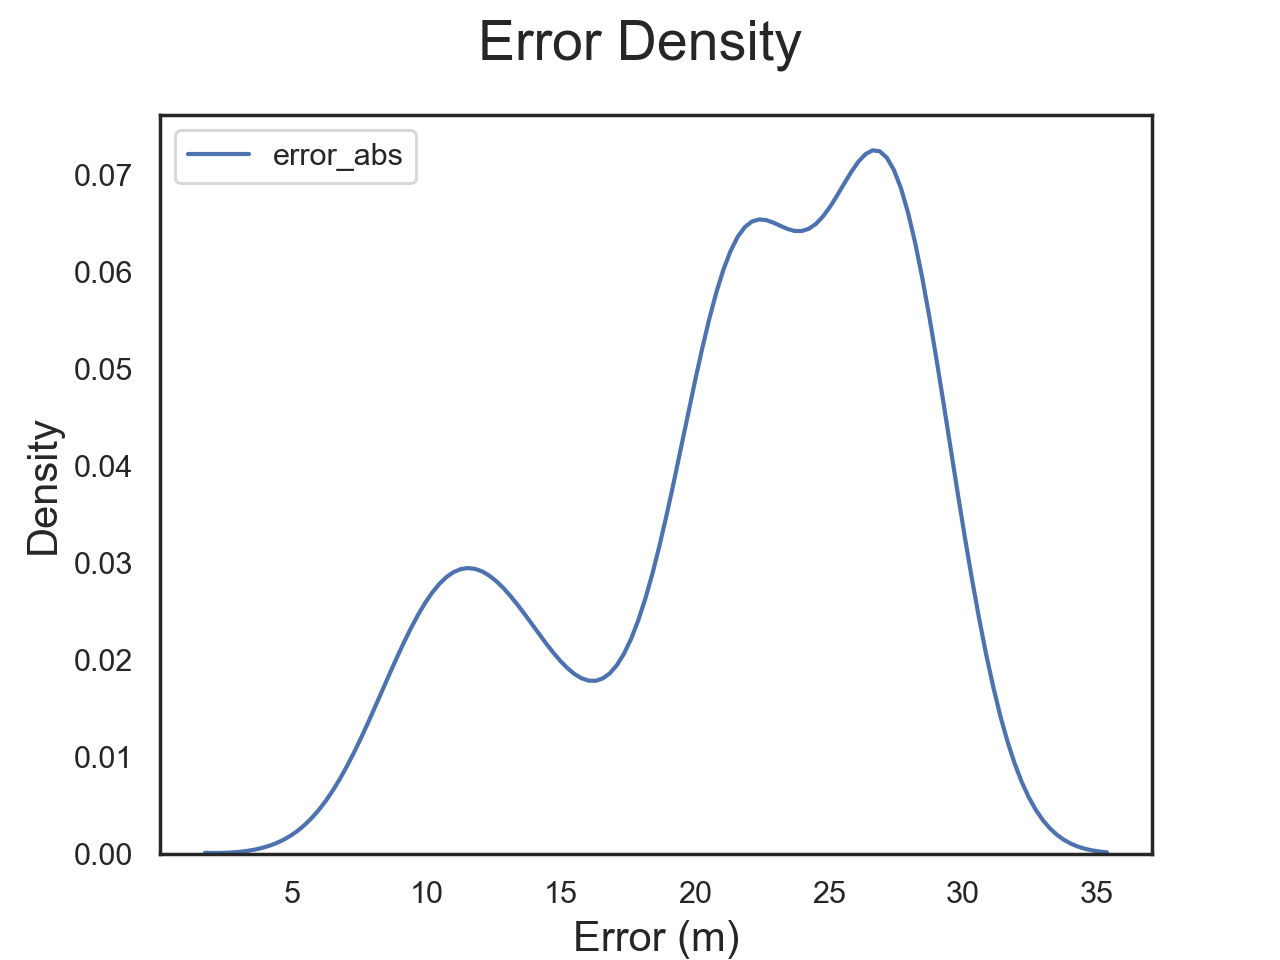

Text(0, 0.5, 'Density')

In [55]:
fig2 = plt.figure()
ax2 = fig2.gca()
sns.kdeplot(dataStat['error_abs'])
fig2.suptitle('Error Density', fontsize=20)
ax2.set_xlabel('Error (m)', fontsize=15)
ax2.set_ylabel('Density', fontsize=15) 

<IPython.core.display.Javascript object>


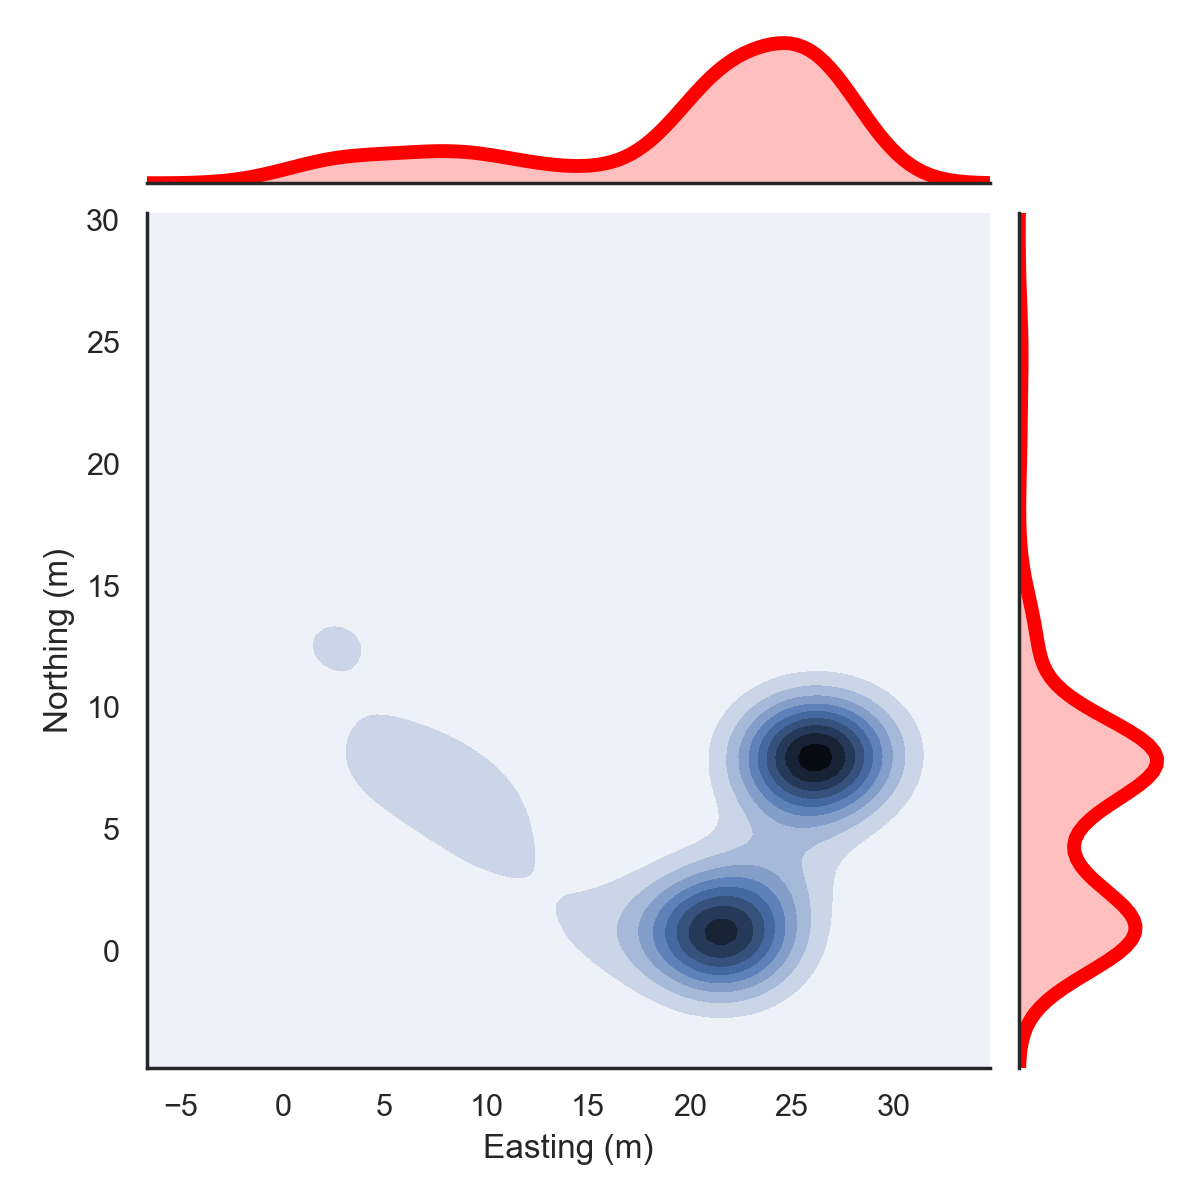

In [56]:
# 2 dimensional KDE
sns.set(style="white", color_codes=True)
ax = sns.jointplot(
    x=dataStat["error_east"],
    y=dataStat["error_north"],
    kind='kde',
    marginal_kws={'lw':5,
                 'color':'red'})
ax.set_axis_labels('Easting (m)', 'Northing (m)')

In [92]:
# Print summary statistics
pd.set_option("display.width", 250)
d = dataStat.describe()[['utm_easting','utm_northing','error_abs']]
d.columns = ['Easting (m)', 'Northing (m)', 'Error (m)']
d

Easting (m)        Northing (m)         Error (m)
count     200.000000000000  2.000000000000e+02  200.000000000000
mean   328921.645937499998  4.690973090000e+06   21.573843797745
std         7.754869163333  5.593822867356e+00    6.040981155849
min    328901.312500000000  4.690943500000e+06    8.394263294330
25%    328918.867187500000  4.690968500000e+06   18.728832146299
50%    328923.500000000000  4.690975000000e+06   21.694261914152
75%    328927.687500000000  4.690977000000e+06   27.106639523462
max    328929.343750000000  4.690983500000e+06   28.717320149480